# Subsurface Machine Learning



## Project Scope:  Impact of Kernel Size on Convolutional Neural Network (CNN) Accuracy

Objective: To determine how varying filter sizes in a CNN affects the model's ability to accurately identify lines of varying lengths in images.

## Executive Summary

After setting a fixed seed and disabling shuffling, the CNN models with varying kernel sizes (3x3, 5x5, 7x7) showed consistent performance in repeated runs. The training loss graphs indicate that all models learn effectively, with smaller kernels initially converging faster. However, as epochs increase, all kernel sizes reach similar training loss values, suggesting that the choice of kernel size has less impact on the final model performance. We then checked the MSE of Line Length Prediction for Different Kernel Sizes on Training Data and found that overall (7x7) kernel does a better job at predicting line length. Similar results could be seen for testing dataset where (3x3) trains faster than other Kernel sizes.

### **Workflow**


1.   Data Preparation: Create dataset of images with varying line length.
2.   Split the Dataset intro Training and Test set.
3.   Model Building: Design a base CNN model with relatively simple architecture of single convolution layer.
4. Change Kernel Size (e.g., 3x3, 5x5, 7x7) while keeping other architecture parameters constant.
5. TRAIN each model on the training set, using the same hyperparameters (epochs, batch size, optimizer, etc.) for a fair comparison.
6. EVALUATE each model's performance on the test set. Compare the accuracy of the models with different kernel size.
7. ANALYZE on how kernel size affects the model's ability to recognize different line patterns.
8. FUTURE Investigations:
Experemient with additional variations in the architecture, such as number of convolutional layers (depth of the network), number of filters, stride. Try using regularization techniques like dropout or data augmentiation.

## What exactly is a CNN?

Convolutional Neural Networks (ConvNets or CNN) are a powerful type of deep learning model specifically designed for processing and analyzing visual data, such as images and videos. They have revolutionized the field of Computer Vision, enabling remarkable advancements in tasks like Image Recognition, Object Detection, and Image Segmentation. {Ref: https://medium.com/codex/understanding-convolutional-neural-networks-a-beginners-journey-into-the-architecture-aab30dface10}

Figure shows a sample CNN architecture used for classification and steps involved:
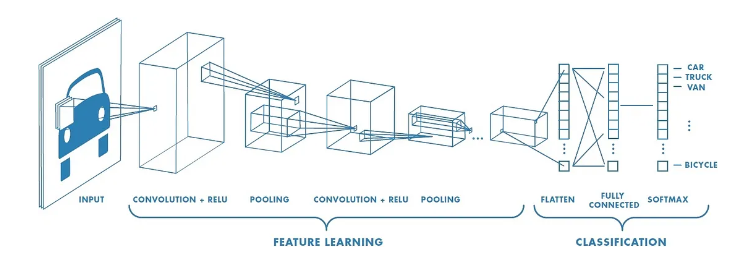

**Some useful Defintions:**
1. **Pooling Operation** - A pooling operation in the context of neural networks, particularly in CNN, is a form of downsampling that reduces the spatial dimensions (height and width) of the input feature maps.

2. **Flatten** - Flatten operation is a process that converts the multi-dimensional output of the convolutional and pooling layers into a one-dimensional array.

3. **Softmax Function** - A mathematical formula that turns a vector of numerical values into a probability distribution. Each output value represents the probability that the input belongs to a particular class in a classification task. This function is commonly used in neural networks to interpret the final layer's outputs as probabilities.




## Setting up Environment

### Imports

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import ipywidgets as widgets
from IPython.display import display
# Set the seed for NumPy generated random numbers
np.random.seed(73073)
# Set the seed for Python generated random numbers
random.seed(73073)
# Set the seed for TensorFlow
tf.random.set_seed(73073)

### Functions Used



* **Function: generate_image_with_horizontal_line**

**Description:**
This function generates a synthetic 2D image of a specified size with a single horizontal line. The line is created by setting pixel values to 1 (on a scale where 0 represents the absence of a line, and 1 represents the presence of a line), creating a clear contrast between the line and the background. The position and length of the line are determined by the parameters provided to the function.

  > **Parameters:**
  image_size (tuple of ints): The dimensions of the image (height, width).
line_length (int): The length of the horizontal line to be drawn in the image.
margin_left (int): The horizontal (leftward) starting position of the line.
margin_top (int): The vertical (upward) starting position of the line, which determines the row in which the line will be placed.

> Returns: image (2D NumPy array): The generated image as a 2D array with pixel values set to 0 or 1.


*   **Function: cnn_model**

**Description:**
This function constructs a Convolutional Neural Network (CNN) model tailored for a regression task. The model consists of a single convolutional layer with a specified kernel size, followed by a flattening layer and a dense output layer with a single neuron. The ReLU activation function is applied in the convolutional layer to introduce non-linearity. The model is compiled with the Adam optimizer and uses mean squared error as the loss function, which is standard for regression problems.

  > **Parameters:**
  kernel_size (tuple of ints): The dimensions of the convolutional window used to traverse the input image (height, width).

> Returns: model (tf.keras.Model): The compiled CNN model ready for training.



*   **Function: calculate_accuracy_for_line_length**

**Description:**
This function evaluates the accuracy of multiple Convolutional Neural Network (CNN) models in predicting the length of horizontal lines in images. For a given line length, it filters the images that contain lines of that length, performs predictions using each model, and calculates the accuracy as the proportion of correct predictions.

  > **Parameters:**
models (dict): A dictionary of compiled CNN models keyed by their kernel size.
train_images (array-like): The collection of images used for evaluating the models.
train_line_lengths (array-like): The corresponding true lengths of lines in train_images.
line_length (int): The specific line length for which to calculate the models' prediction accuracies.

> Returns: accuracies (dict): A dictionary with the kernel sizes as keys and the calculated accuracies as values. If no images match the specified line_length, it returns None for all model accuracies.




In [2]:
# Function to generate an image with a single horizontal line
def generate_image_with_horizontal_line(image_size, line_length, margin_left, margin_top):
    image = np.zeros(image_size)
    y = margin_top
    x_start = margin_left
    x_end = x_start + line_length
    image[y, x_start:x_end] = 1  # Set the pixels of the line to 1
    return image

# Function to create a CNN model with a single convolutional layer of a given kernel size
def cnn_model(kernel_size):
    model = Sequential([
        Conv2D(filters=16, kernel_size=kernel_size, activation='relu', input_shape=(28, 28, 1)),
        Flatten(),
        Dense(1)  # Single output node for regression
    ])
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# #For Calculating Line Length Prediction Accuracy
def calculate_accuracy_for_line_length(model, filtered_images, filtered_true_lengths, threshold=1):
    # Reshape images for compatibility with the model
    filtered_images_reshaped = filtered_images.reshape((-1, 28, 28, 1))

    # Predict using the model
    predictions = model.predict(filtered_images_reshaped).flatten()

    # Calculate accuracy within a certain threshold (e.g., ±1)
    correct_predictions = np.sum(np.abs(predictions - filtered_true_lengths) <= threshold)
    accuracy = correct_predictions / len(filtered_true_lengths) * 100
    return accuracy

## Generating 50 Input Synthetic Dataset

In this problem: I've developed a single-layer Convolutional Neural Network (CNN) to analyze a dataset of 50 synthetic images, each containing a horizontal line of varying length. The random lines are generated such that they have appropriate data distribution across all line length.


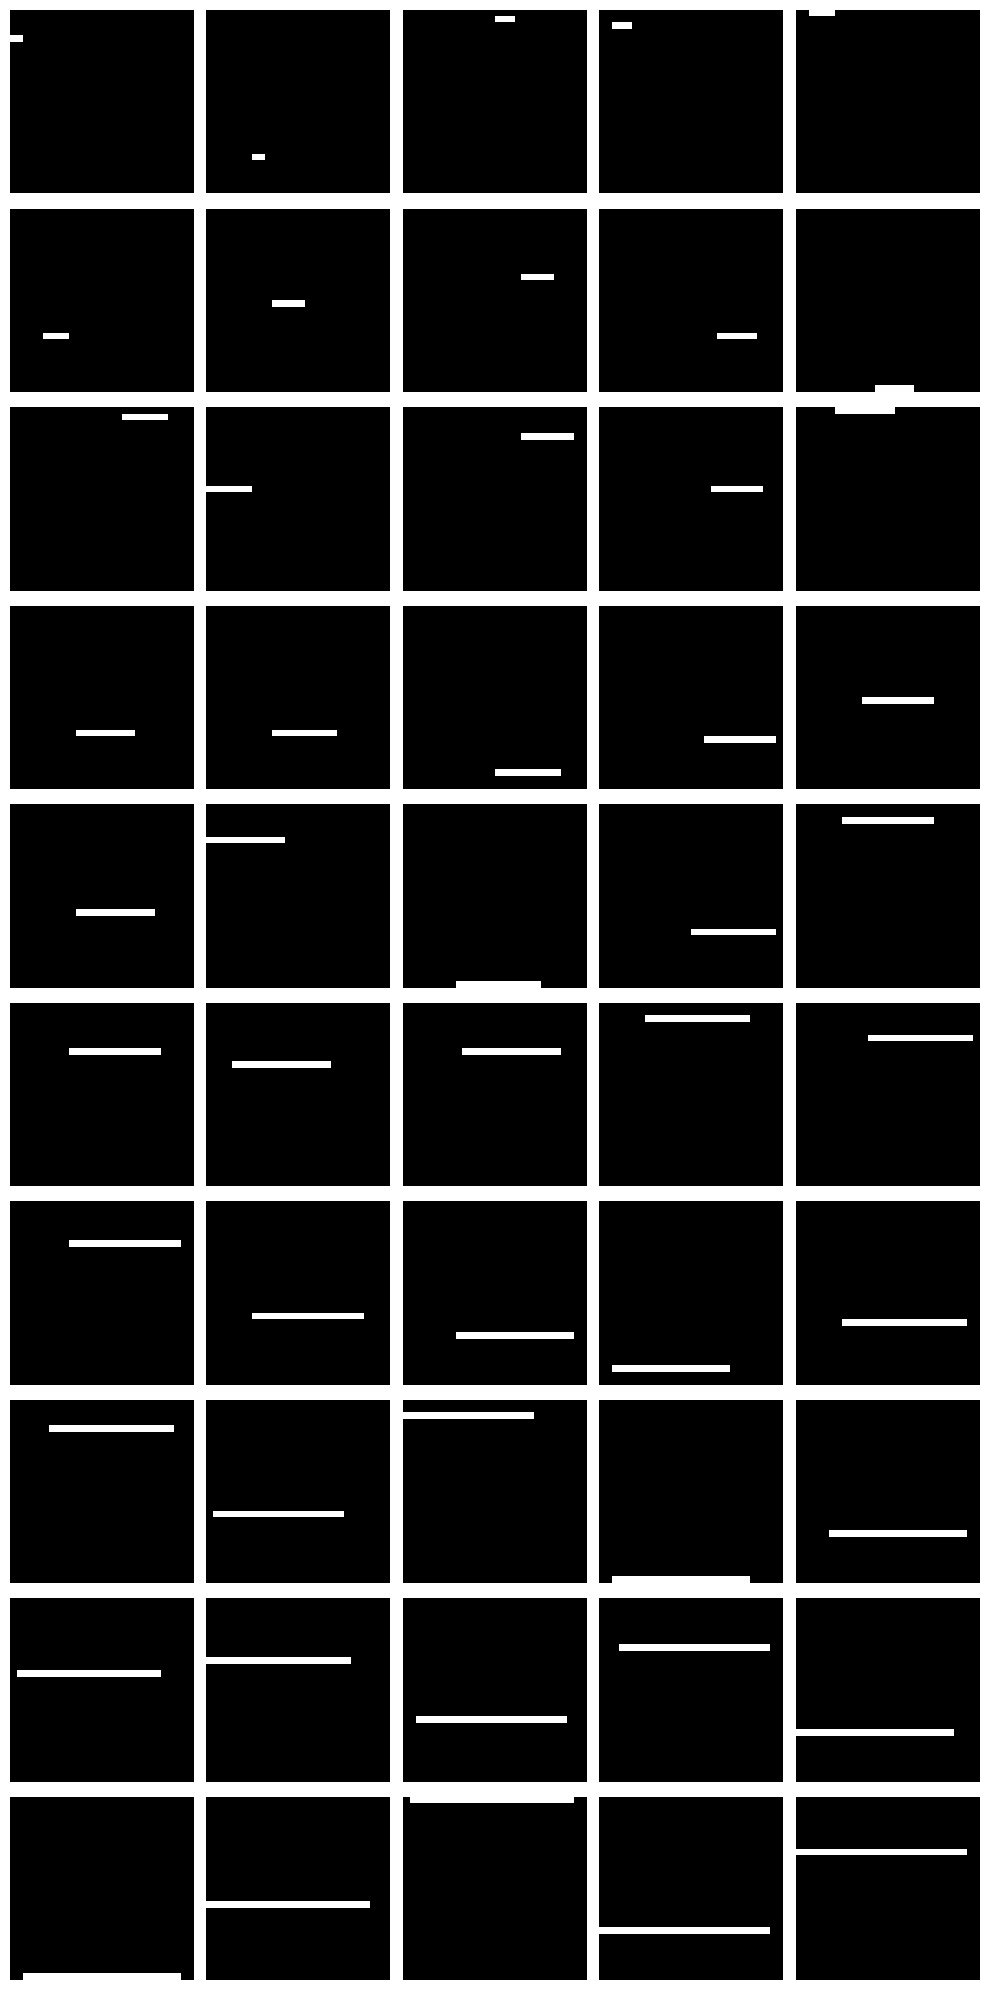

In [3]:
# Parameters for synthetic dataset
num_images = 50
image_size = (28, 28)  # Using a standard small image size

# Desired number of images per line length
images_per_length = num_images // (image_size[1] - 7)  # subtract 5 for max length and 2 for min length

# Create dataset with an even distribution
dataset = []
line_lengths = []
for line_length in range(2, image_size[1] - 1):
    for _ in range(images_per_length):
        margin_left = np.random.randint(0, image_size[1] - line_length)
        margin_top = np.random.randint(0, image_size[0])
        image = generate_image_with_horizontal_line(image_size, line_length, margin_left, margin_top)
        dataset.append(image)
        line_lengths.append(line_length)

# Now, line_lengths should have an even distribution


# Display all 50 images from the dataset
fig, axes = plt.subplots(10, 5, figsize=(10, 20))  # 10 rows and 5 columns to display 50 images
axes = axes.flatten()
for img, ax in zip(dataset, axes):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Splitting Dataset into Train-Test

I have split my dataset into Train-Test split ratio of (75-25). For the ease of reproducibility of my results, I have turned of the Data Shuffle during the split.  

In [4]:
# Convert dataset to numpy array for easier processing
dataset_array = np.array(dataset)
line_lengths = np.array(line_lengths)
line_lengths.shape
# Splitting the dataset into training and testing sets (75:25 ratio)
train_images, test_images = train_test_split(dataset_array, test_size=0.25, shuffle = False)
train_line_lengths, test_line_lengths = train_test_split(line_lengths, test_size=0.25, shuffle = False)


# # Checking the shape of the training and testing sets
train_images.shape, test_images.shape

((37, 28, 28), (13, 28, 28))

#### Preprocessing the Dataset

In [5]:
# Preprocessing the data
# Reshape the images to add a channel dimension (needed for CNNs)
# Assuming your images are grayscale, so the channel dimension is 1
train_images_reshaped = train_images.reshape(-1, 28, 28, 1)
test_images_reshaped = test_images.reshape(-1, 28, 28, 1)

# Normalize the images if they aren't already (this depends on how you generated the images)
# Skip this step if your images are already in the range [0, 1]
train_images_reshaped = train_images_reshaped / 255.0
test_images_reshaped = test_images_reshaped / 255.0

## Creating Models with Varying Kernel Size

---

Here I have chosen to create models of three Kernel Size (3x3), (5x5), and (7x7).

**What are Kernels?**
Kernels in CNN are small matrices used to extract features from images by sliding over them and performing element-wise multiplication.

For Example as shown in the image below {Ref: https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148}

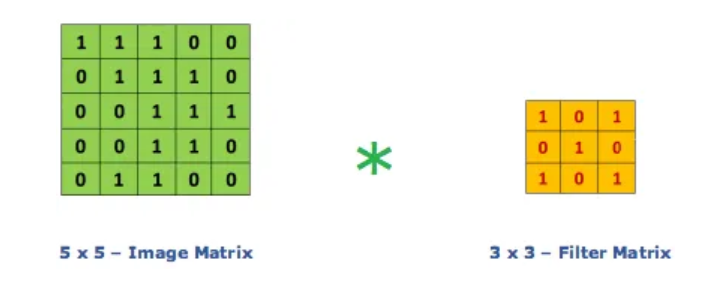


**This Results in a sample result like this for a (3x3) matrix:**


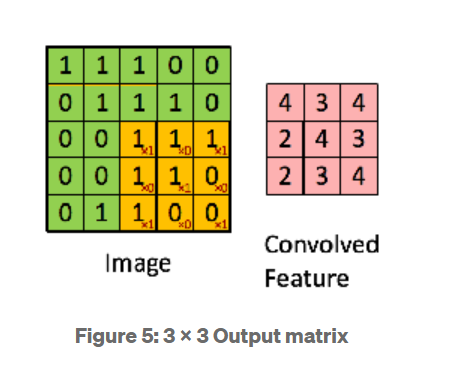

In [6]:
# Create models with different kernel sizes
kernel_sizes = [(3, 3), (5, 5), (7, 7)]
models = {str(k): cnn_model(k) for k in kernel_sizes}

3 Different Kernel Sizes (3x3), (5x5), and (7x7) are created for training the model.

#### Model Training

In [7]:
# Training each model
num_epochs = 60  # Number of epochs for training
batch_size = 16  # Batch size for training

history = {}  # Dictionary to store training history for each model

for kernel_size, model in models.items():
    print(f"Training model with kernel size: {kernel_size}")
    model_history = model.fit(train_images_reshaped, train_line_lengths, epochs=num_epochs, batch_size=batch_size, shuffle = False)
    history[kernel_size] = model_history

    # Optional: Save the model for later use
    model.save(f'model_{kernel_size}.h5')

# After training, 'history' will contain the training history for each model


Training model with kernel size: (3, 3)
Epoch 1/60
3/3 [==============================] - 1s 23ms/step - loss: 144.2036
Epoch 2/60
3/3 [==============================] - 0s 12ms/step - loss: 143.3621
Epoch 3/60
3/3 [==============================] - 0s 11ms/step - loss: 141.1190
Epoch 4/60
3/3 [==============================] - 0s 20ms/step - loss: 137.1999
Epoch 5/60
3/3 [==============================] - 0s 17ms/step - loss: 131.4483
Epoch 6/60
3/3 [==============================] - 0s 21ms/step - loss: 123.8011
Epoch 7/60
3/3 [==============================] - 0s 16ms/step - loss: 114.3147
Epoch 8/60
3/3 [==============================] - 0s 18ms/step - loss: 103.1905
Epoch 9/60
3/3 [==============================] - 0s 15ms/step - loss: 90.7964
Epoch 10/60
3/3 [==============================] - 0s 15ms/step - loss: 77.6770
Epoch 11/60
3/3 [==============================] - 0s 19ms/step - loss: 64.5431
Epoch 12/60
3/3 [==============================] - 0s 40ms/step - loss: 52.2309
E

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 10ms/step - loss: 144.1638
Epoch 2/60
3/3 [==============================] - 0s 14ms/step - loss: 143.2483
Epoch 3/60
3/3 [==============================] - 0s 13ms/step - loss: 141.0639
Epoch 4/60
3/3 [==============================] - 0s 11ms/step - loss: 137.4172
Epoch 5/60
3/3 [==============================] - 0s 13ms/step - loss: 132.1832
Epoch 6/60
3/3 [==============================] - 0s 12ms/step - loss: 125.3042
Epoch 7/60
3/3 [==============================] - 0s 13ms/step - loss: 116.8101
Epoch 8/60
3/3 [==============================] - 0s 9ms/step - loss: 106.8382
Epoch 9/60
3/3 [==============================] - 0s 14ms/step - loss: 95.6497
Epoch 10/60
3/3 [==============================] - 0s 22ms/step - loss: 83.6398
Epoch 11/60
3/3 [==============================] - 0s 17ms/step - loss: 71.3355
Epoch 12/60
3/3 [==============================] - 0s 10ms/step - loss: 59.3742
Epoch 13/60
3/3 [==============================] - 0s

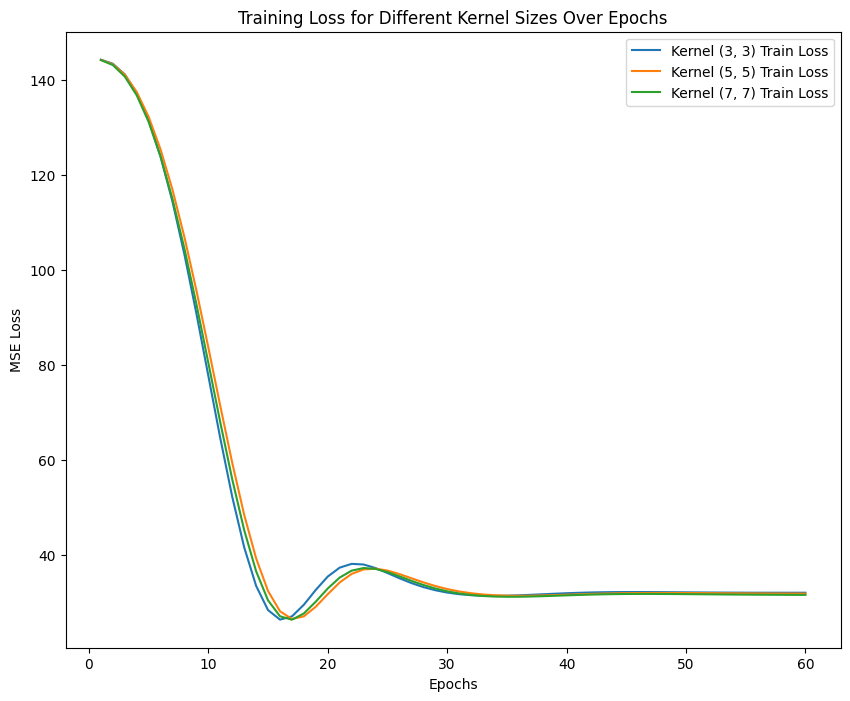

In [8]:
# Each history object has a 'loss' for training
# The keys are the string representation of the kernel sizes, e.g., '3x3'

# Number of epochs trained for
num_epochs = 60

# Create a range object for epochs
epochs = range(1, num_epochs + 1)

# Plot training and validation loss for each model
plt.figure(figsize=(10, 8))

for kernel_size, model_history in history.items():
    train_loss = model_history.history['loss']
    plt.plot(epochs, train_loss, label=f'Kernel {kernel_size} Train Loss')

plt.title('Training Loss for Different Kernel Sizes Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

**MSE of Line Length Prediction for Different Kernel Sizes on Training Data**

In this model we're trying to model the MSE of line length prediction for Different Kernel Sizes on Training Data.

In [9]:
# Load the pre-trained models (assuming they are saved with the following names)
kernel_sizes = [(3, 3), (5, 5), (7, 7)]
models = {str(k): load_model(f'model_{k}.h5') for k in kernel_sizes}

# We will store MSE for each line length for each model
mse_per_length = {str(k): [] for k in kernel_sizes}
line_length_range = np.unique(train_line_lengths)  # This will give us the unique line lengths in the train set

# Calculate MSE for each line length
for line_length in line_length_range:
    # Filter train images and lengths for the current line length
    indices = np.where(train_line_lengths == line_length)
    train_images_ll = train_images_reshaped[indices]
    train_lengths_ll = train_line_lengths[indices]

    for kernel_size, model in models.items():
        # Predict line lengths for the filtered train images
        predicted_lengths = model.predict(train_images_ll).flatten()
        # Calculate MSE for the current line length
        mse = mean_squared_error(train_lengths_ll, predicted_lengths)
        mse_per_length[kernel_size].append(mse)

1/1 [==============================] - 0s 21ms/step


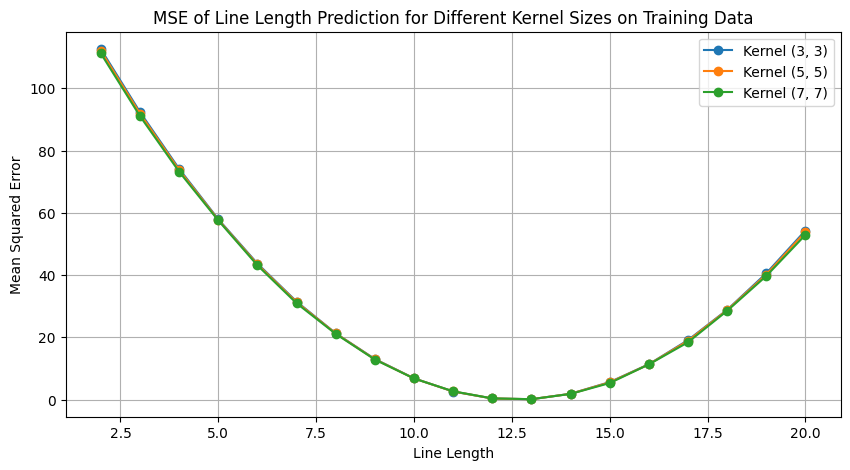

In [10]:
# Now we have the MSE for each line length for each kernel size, we can plot this data
plt.figure(figsize=(10, 5))

# Plotting MSE for each kernel size
for kernel_size, mse_values in mse_per_length.items():
    plt.plot(line_length_range, mse_values, marker='o', label=f'Kernel {kernel_size}')

plt.title('MSE of Line Length Prediction for Different Kernel Sizes on Training Data')
plt.xlabel('Line Length')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()


It appears from the plot that (7x7) does perform slightly better than the other kernel sizes. Although a bigger difference in results could be expected if the number of input dataset was increased in magnitude order for a single layer convolution layer

### Interactive Plot

Just to see how different Kernel sizes perform by sliding over the epoch range (1, 60). At Epoch = 60 all the models are fully trained. This is done to see which model gets prepared earlier and then which kernel size performs better when all the models are unprepared.

In [11]:
import ipywidgets as widgets
from IPython.display import display

# Dictionary to store the history
history = {str(kernel_size): {'epochs': list(range(1, num_epochs + 1)),
                              'line_lengths': {length: [] for length in line_length_range}}
           for kernel_size in kernel_sizes}

for kernel_size, model in models.items():
    for epoch in range(1, num_epochs + 1):
        model.fit(train_images_reshaped, train_line_lengths, epochs=1, batch_size=batch_size, verbose=0)
        for line_length in line_length_range:
            # Filter images for the current line length
            indices = np.where(train_line_lengths == line_length)
            images_ll = train_images_reshaped[indices]
            lengths_ll = train_line_lengths[indices]

            # Evaluate MSE for the current line length
            mse = model.evaluate(images_ll, lengths_ll, verbose=0)
            history[str(kernel_size)]['line_lengths'][line_length].append(mse)

def plot_mse_for_epoch_and_kernel(epoch, kernel_size):
    plt.figure(figsize=(10, 5))
    mse_values = history[kernel_size]['line_lengths']
    line_lengths = list(mse_values.keys())
    mse_epoch_values = [mse_values[length][epoch-1] for length in line_lengths]

    plt.plot(line_lengths, mse_epoch_values, marker='o')
    plt.xlabel('Line Length')
    plt.ylabel('MSE')
    plt.title(f'MSE for Line Lengths - Kernel Size {kernel_size}, Epoch {epoch}')
    plt.grid(True)
    plt.show()

epoch_slider = widgets.IntSlider(min=1, max=60, step=1, value=1, description='Epoch:')
kernel_size_widget = widgets.Dropdown(options=[str(k) for k in kernel_sizes], description='Kernel Size:')

widgets.interact(plot_mse_for_epoch_and_kernel, epoch=epoch_slider, kernel_size=kernel_size_widget)

interactive(children=(IntSlider(value=1, description='Epoch:', max=60, min=1), Dropdown(description='Kernel Si…

<function __main__.plot_mse_for_epoch_and_kernel(epoch, kernel_size)>

As you can see from the above plot that (3x3) can assert performance dominance until Epoch < 20. This happens because the other Kernel sizes aren't fully trained [(3x3) kernel trains faster than (5x5) or (7x7) Kernels].

### Model Testing

In [12]:
# Testing each model
num_epochs = 60 # Number of epochs for Testing
batch_size = 10  # Batch size for testing

history_test = {}  # Dictionary to store testing history for each model

for kernel_size, model in models.items():
    print(f"Testing model with kernel size: {kernel_size}")
    model_history_test = model.fit(test_images_reshaped, test_line_lengths, epochs=num_epochs, batch_size=batch_size, shuffle = False)
    history_test[kernel_size] = model_history_test

# After Testing, 'history' will contain the Testing history for each model


Testing model with kernel size: (3, 3)
Epoch 1/60
2/2 [==============================] - 0s 12ms/step - loss: 171.6724
Epoch 2/60
2/2 [==============================] - 0s 10ms/step - loss: 159.4334
Epoch 3/60
2/2 [==============================] - 0s 10ms/step - loss: 136.0181
Epoch 4/60
2/2 [==============================] - 0s 9ms/step - loss: 105.9501
Epoch 5/60
2/2 [==============================] - 0s 9ms/step - loss: 73.8086
Epoch 6/60
2/2 [==============================] - 0s 9ms/step - loss: 44.1191
Epoch 7/60
2/2 [==============================] - 0s 9ms/step - loss: 20.8867
Epoch 8/60
2/2 [==============================] - 0s 9ms/step - loss: 6.8389
Epoch 9/60
2/2 [==============================] - 0s 9ms/step - loss: 2.6229
Epoch 10/60
2/2 [==============================] - 0s 9ms/step - loss: 6.4000
Epoch 11/60
2/2 [==============================] - 0s 10ms/step - loss: 14.3265
Epoch 12/60
2/2 [==============================] - 0s 10ms/step - loss: 22.0091
Epoch 13/60
2/2 

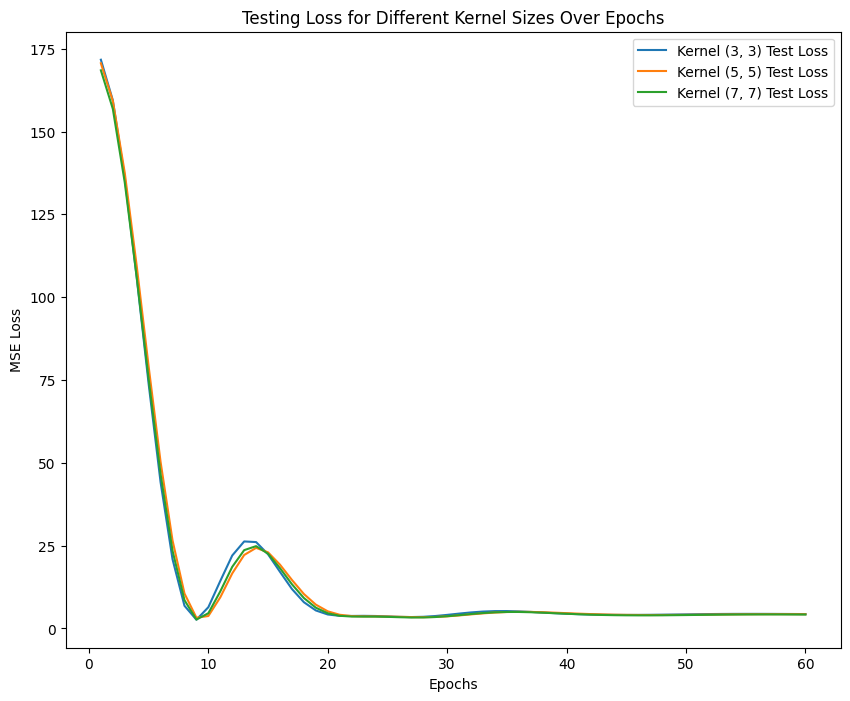

In [13]:
# Each history_test object has a 'loss' for Testing
# The keys are the string representation of the kernel sizes, e.g., '3x3'

# Number of epochs trained for
num_epochs = 60

# Create a range object for epochs
epochs = range(1, num_epochs + 1)

# Plot training and validation loss for each model
plt.figure(figsize=(10, 8))

for kernel_size, model_history_test in history_test.items():
    test_loss = model_history_test.history['loss']
    plt.plot(epochs, test_loss, label=f'Kernel {kernel_size} Test Loss')

plt.title('Testing Loss for Different Kernel Sizes Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

Similar Result in testing dataset as well. Where (3x3) Kernel size trains faster than other Kernel Sizes.